# Metropolis sampling

In this notebook we analyse the results from VMC calculations on a spherical harmonic oscillator using brute force Metropolis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from vmc.interface import PyHarmonicOscillator, PyMetropolisAlgorithm, \
    PySimpleGaussian, PySimpleGaussianNumerical, PySampler, \
    PyImportanceMetropolis
from vmc import run_experiment

from IPython.core.pylabtools import figsize
from IPython.core.display import display

In [2]:
sns.set(color_codes=True)
#figsize(14, 10)

We use natural units with $m = \hbar = c = 1$. We also restrict our views to $\omega = 1$ in this analysis.

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

step_length = 1.0

h = 1e-7

## The one dimensional spherical harmonic oscillator

Starting with the simplest case we look at the one dimensional spherical harmonic oscillator.

\begin{align}
    \Psi_T(\mathbf{x}) &= \prod_{i = 1}^N\exp(-\alpha x_i).
\end{align}

We wish to compare the CPU time of the analytical scheme, i.e., an analytical expression for the Laplcian and hence the local energy, versus a central difference scheme of second order.

We know that the exact ground state energy for the one dimensional spherical harmonic oscillator can be found at $\alpha = 0.5$. By restricting our view to the region $\alpha \in [0.1, 0.7]$ we should observe a trend where the average energy goes towards a minimum at $\alpha = 0.5$ and increases on both sides.

In [4]:
alpha_min = 0.3
alpha_max = 0.9
num_alphas = 31

parameter_names = ["alpha"]

alphas = np.linspace(
    alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

In [5]:
num_particles = 2
num_dimensions = 3

num_samples = int(1e5)
num_thermalization_steps = int(num_particles * 2000)

In [6]:
kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [7]:
solver_analytical = PyMetropolisAlgorithm()
#solver = PyImportanceMetropolis(num_particles)
wavefunction_analytical = PySimpleGaussian(
    num_particles, num_dimensions, mass, omega, spread=step_length)
hamiltonian_analytical = PyHarmonicOscillator()
sampler_analytical = PySampler(
    wavefunction_analytical, hamiltonian_analytical,
    solver_analytical)

In [8]:
solver_approximate = PyMetropolisAlgorithm()
wavefunction_approximate = PySimpleGaussianNumerical(
    num_particles, num_dimensions, mass, omega, h=h, spread=step_length)
hamiltonian_approximate = PyHarmonicOscillator()
sampler_approximate = PySampler(
    wavefunction_approximate, hamiltonian_approximate,
    solver_approximate)

In [9]:
df_analytical = run_experiment(
    sampler_analytical, wavefunction_analytical, alphas,
    parameter_names, **kwargs)

100%|██████████| 31/31 [00:00<00:00, 45.39it/s]


In [10]:
df_approximate = run_experiment(
    sampler_approximate, wavefunction_approximate, alphas,
    parameter_names, **kwargs)

100%|██████████| 31/31 [00:01<00:00, 26.05it/s]


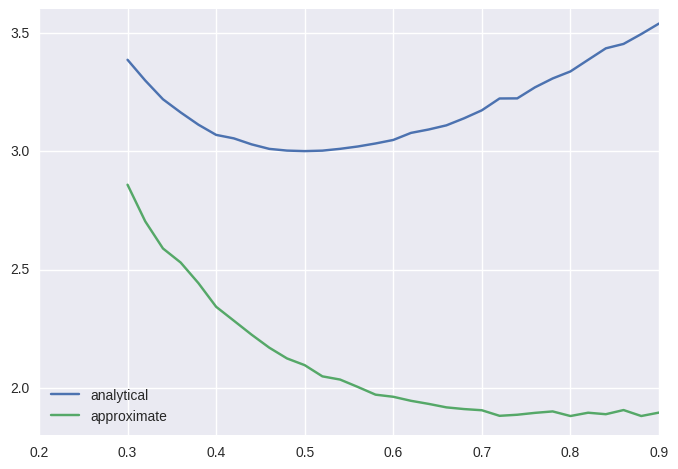

In [11]:
plt.plot(df_analytical["alpha"], df_analytical["energy"], label="analytical")
plt.plot(df_approximate["alpha"], df_approximate["energy"], label="approximate")
plt.legend(loc="best")
plt.show()

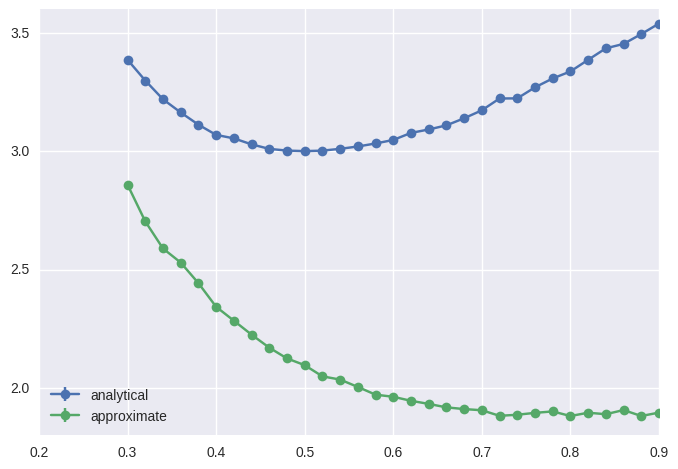

In [12]:
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="approximate", fmt="o-")
plt.legend(loc="best")
plt.show()

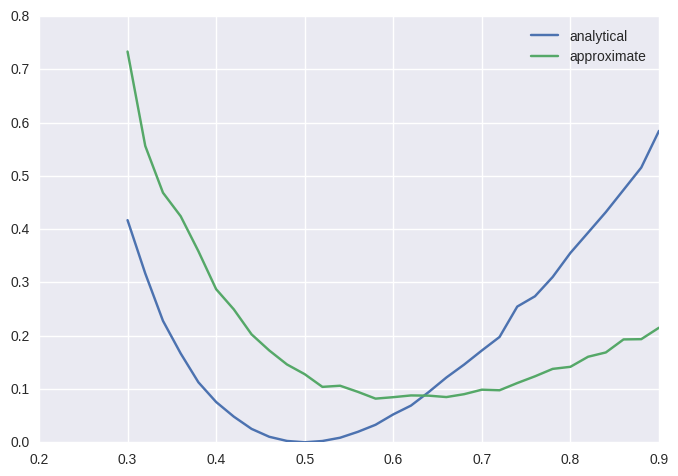

In [13]:
plt.plot(
    df_analytical["alpha"], df_analytical["variance"]/num_particles,
    label="analytical")
plt.plot(
    df_approximate["alpha"], df_approximate["variance"]/num_particles,
    label="approximate")
plt.legend(loc="best")
plt.show()

In [14]:
display(df_analytical)

,alpha,energy,variance,acceptance
0,0.30,3.385686,0.833860,0.60095
1,0.32,3.298072,0.633782,0.59368
2,0.34,3.218910,0.455887,0.57958
3,0.36,3.163266,0.333364,0.57143
4,0.38,3.111603,0.225214,0.55831
5,0.40,3.068545,0.151232,0.54681
6,0.42,3.053797,0.096183,0.54239
7,0.44,3.028561,0.050298,0.52952
8,0.46,3.009452,0.020638,0.52341
9,0.48,3.002209,0.004982,0.51315


In [15]:
display(df_approximate)

,alpha,energy,variance,acceptance
0,0.30,2.858117,1.466711,0.60424
1,0.32,2.703278,1.112391,0.58791
2,0.34,2.588842,0.936768,0.57794
3,0.36,2.529397,0.848498,0.56840
4,0.38,2.442589,0.717200,0.55817
5,0.40,2.342685,0.574796,0.55005
6,0.42,2.283934,0.498818,0.54405
7,0.44,2.224975,0.405183,0.53579
8,0.46,2.169985,0.344650,0.52513
9,0.48,2.124570,0.292133,0.51277


In [16]:
energy_exact = hamiltonian_analytical.compute_exact_energy(
    wavefunction_analytical, alphas=alphas.ravel())

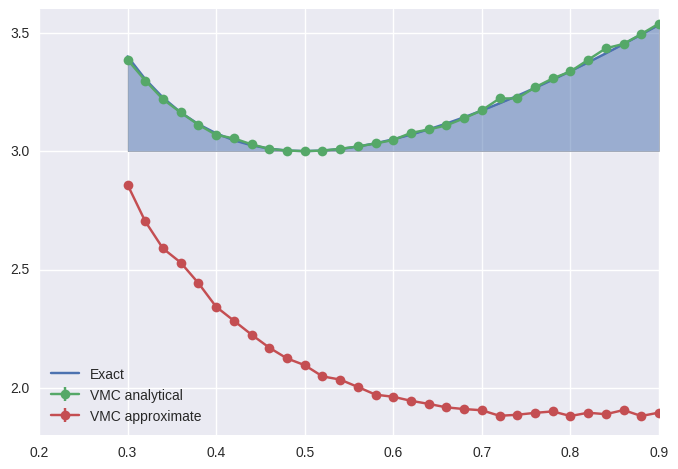

In [17]:
plt.plot(alphas.ravel(), energy_exact, label="Exact")
plt.fill_between(
    alphas.ravel(), min(energy_exact), energy_exact, alpha=0.5)
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="VMC analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="VMC approximate", fmt="o-")
plt.legend(loc="best")
plt.show()

In [42]:
r_min = 0
r_max = 4
num_bins = 100

sampler_analytical.initialize_one_body_densities(r_min, r_max, num_bins)
wavefunction_analytical.set_parameters(np.array([0.5]))
wavefunction_analytical.redistribute()

In [43]:
sampler_analytical.sample(num_samples, step_length)

In [44]:
bins = sampler_analytical.get_one_body_densities()
radius = np.linspace(r_min, r_max, num_bins)

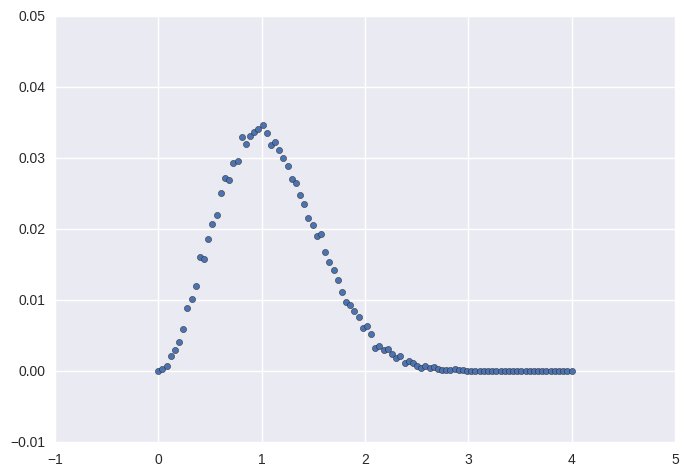

In [45]:
plt.scatter(radius, bins)
plt.show()